In [1]:
from lerobot.common.motors.feetech import FeetechMotorsBus
from lerobot.common.motors import Motor, MotorNormMode
from lerobot.common.motors.motors_bus import MotorCalibration
import time
import joblib
import pandas as pd
from lerobot.common.utils.utils import enter_pressed
from pynput import keyboard
import cv2
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
import tqdm

pd.options.mode.copy_on_write = True

In [2]:
dfs = []

for file_name in os.listdir("recordings"):
    df = pd.read_parquet(os.path.join("recordings", file_name))
    dfs.append(df)

len(dfs)

12

In [3]:
dfs[0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 92 entries, 0 to 91
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   shoulder_pan   92 non-null     float64
 1   shoulder_lift  92 non-null     float64
 2   wrist_flex     92 non-null     float64
 3   wrist_roll     92 non-null     float64
 4   gripper        92 non-null     float64
 5   image          92 non-null     object 
dtypes: float64(5), object(1)
memory usage: 5.0+ KB


In [4]:
for i, df in enumerate(dfs):
    df_no_dups = df.drop_duplicates(
        subset=["shoulder_pan", "shoulder_lift", "wrist_flex", "wrist_roll", "gripper"],
    )
    print(f"{i:3d} - len: {len(df):5d} - len_no_dups: {len(df_no_dups):5d}")

for df in dfs:
    df.drop_duplicates(
        subset=["shoulder_pan", "shoulder_lift", "wrist_flex", "wrist_roll", "gripper"],
        inplace=True,
    )

  0 - len:    92 - len_no_dups:    77
  1 - len:   134 - len_no_dups:   104
  2 - len:    92 - len_no_dups:    66
  3 - len:    80 - len_no_dups:    59
  4 - len:   134 - len_no_dups:   106
  5 - len:   105 - len_no_dups:    80
  6 - len:   154 - len_no_dups:   108
  7 - len:    91 - len_no_dups:    72
  8 - len:    97 - len_no_dups:    76
  9 - len:   219 - len_no_dups:   203
 10 - len:   103 - len_no_dups:    85
 11 - len:   154 - len_no_dups:   134


In [5]:
window_size = 30
motor_windows = []
image_windows = []
targets = []

for df in tqdm.tqdm(dfs):
    for j in range(window_size, len(df)):
        df_tmp = df.iloc[j - window_size : j]
        df_tmp_motor = df_tmp[
            ["shoulder_pan", "shoulder_lift", "wrist_flex", "wrist_roll", "gripper"]
        ]
        df_tmp_image = list(
            map(lambda x: np.array(x).reshape((20, 23, 3)), df_tmp["image"])
        )
        motor_windows.append(df_tmp_motor)
        image_windows.append(df_tmp_image)
        targets.append(
            list(
                df[
                    [
                        "shoulder_pan",
                        "shoulder_lift",
                        "wrist_flex",
                        "wrist_roll",
                        "gripper",
                    ]
                ].iloc[j]
            )
        )

len(motor_windows), len(image_windows), len(targets)

100%|██████████| 12/12 [00:00<00:00, 30.06it/s]


(810, 810, 810)

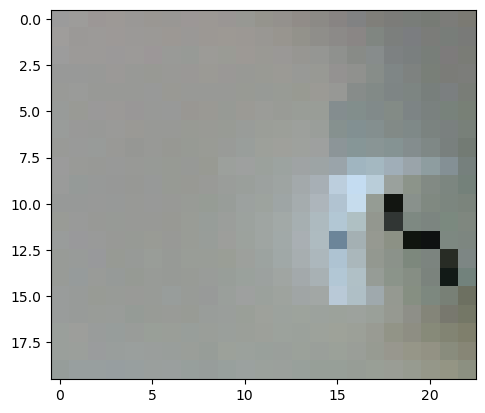

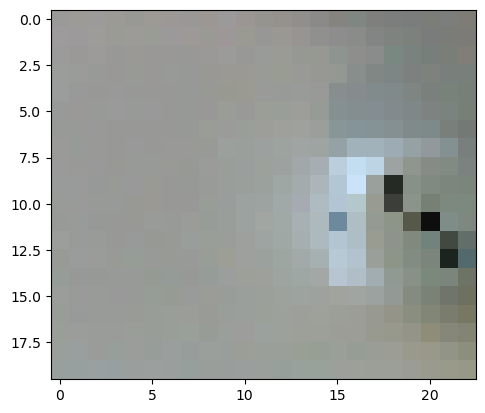

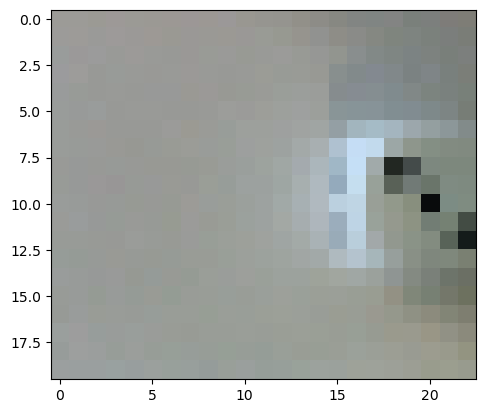

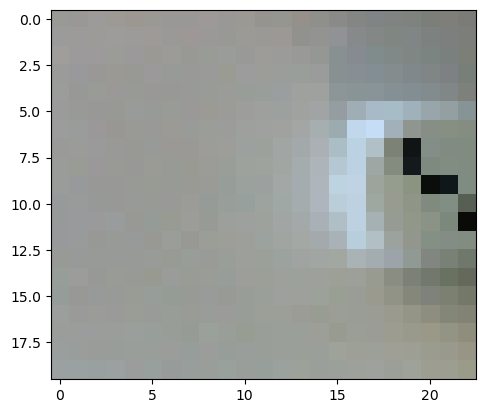

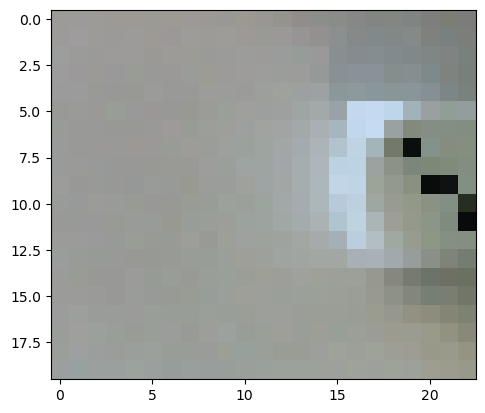

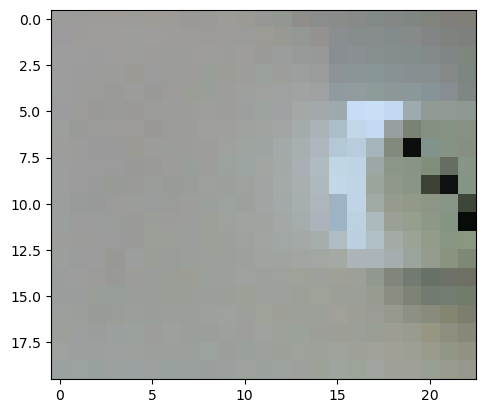

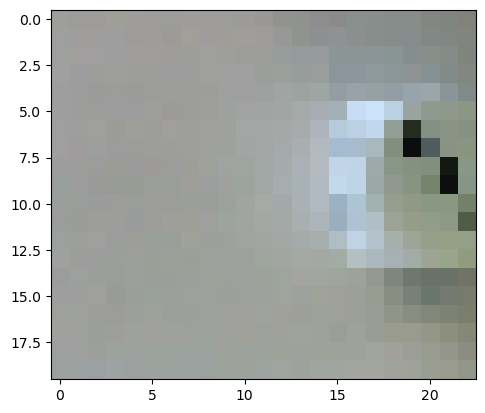

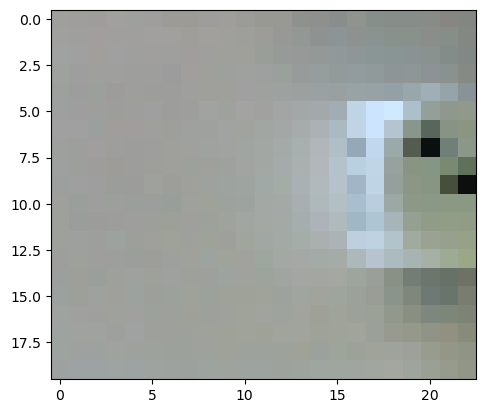

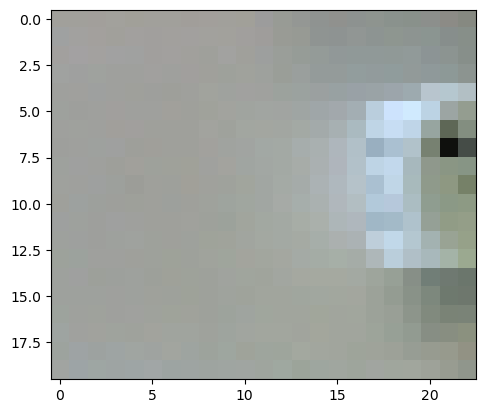

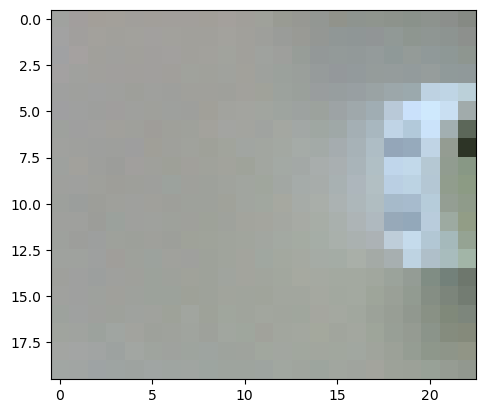

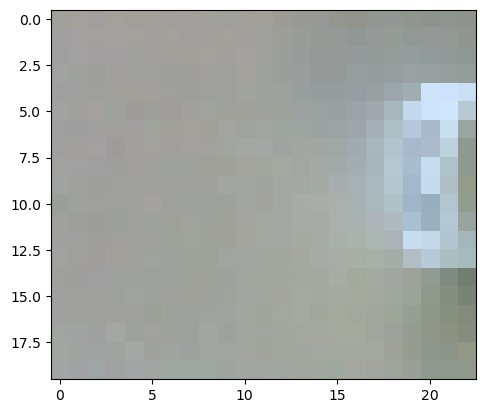

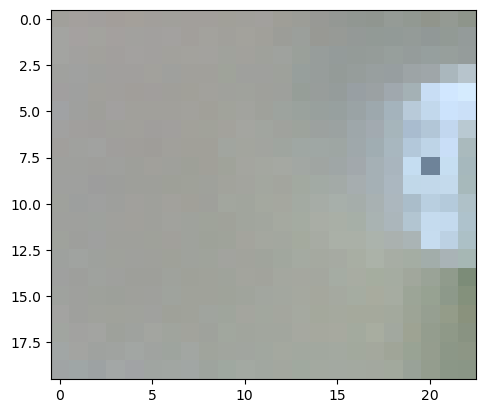

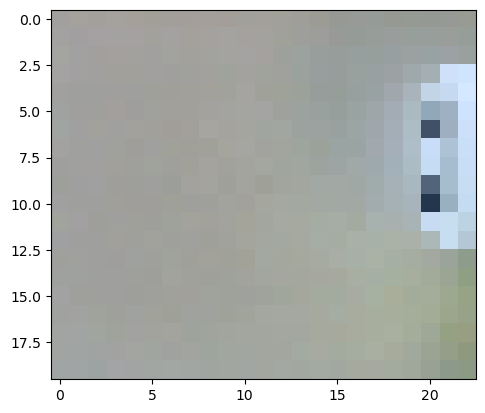

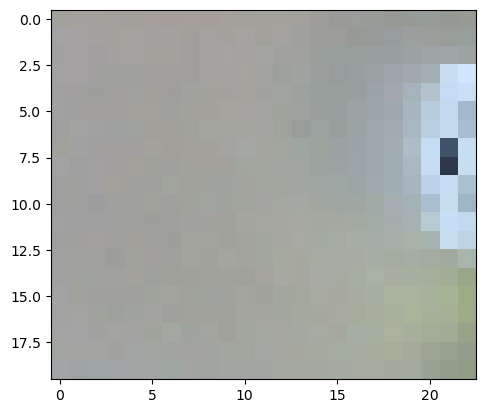

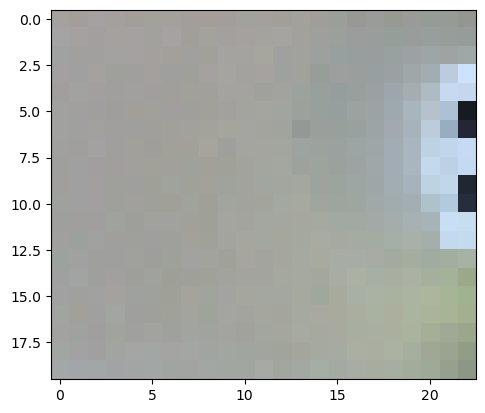

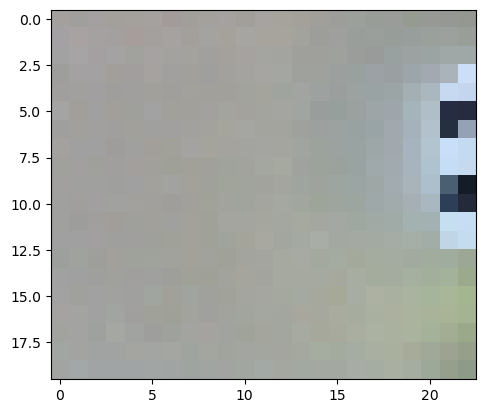

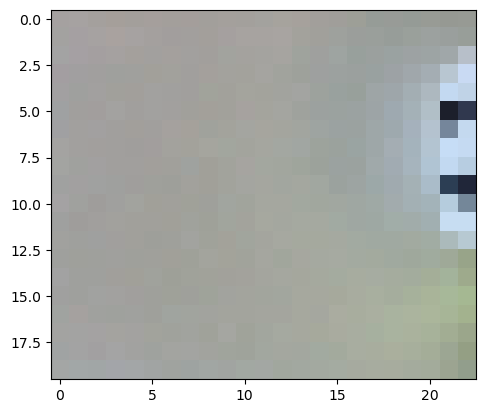

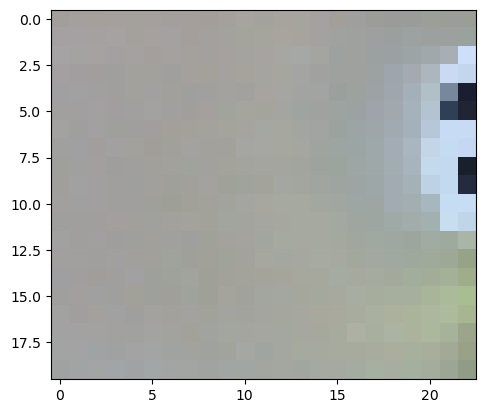

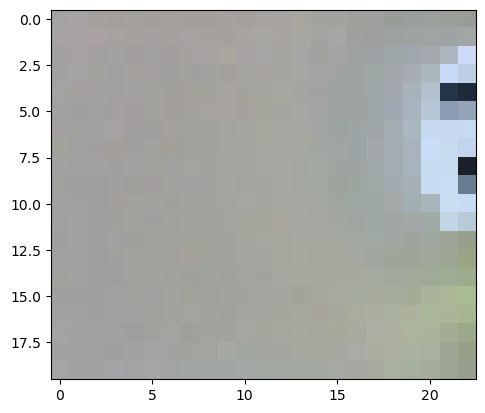

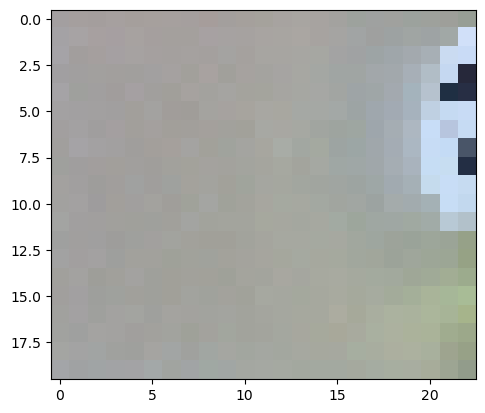

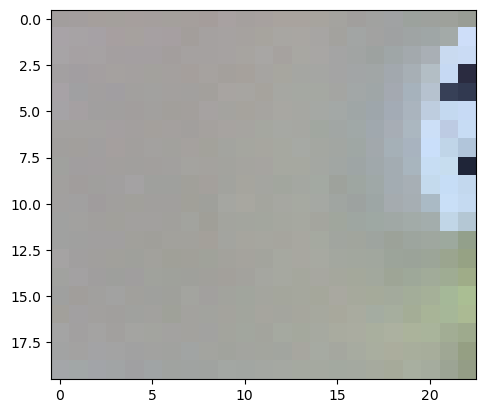

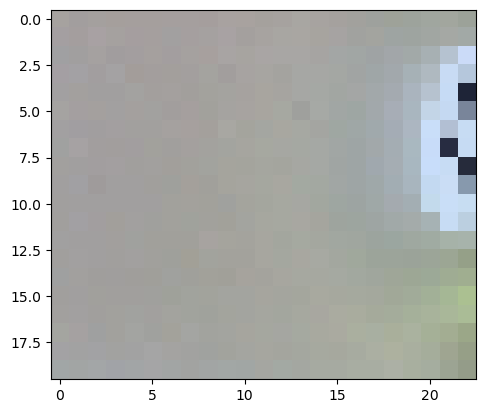

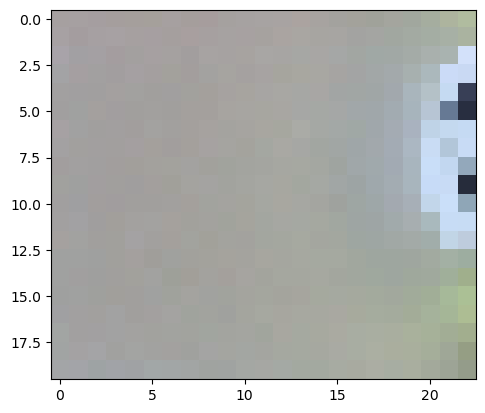

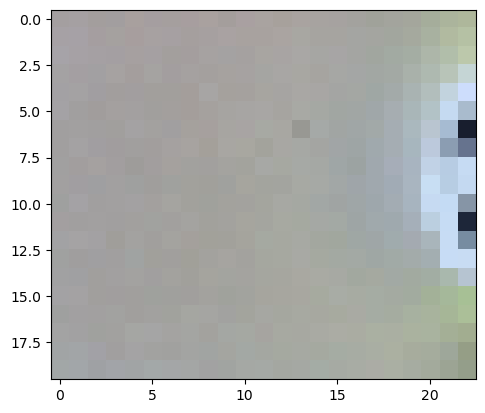

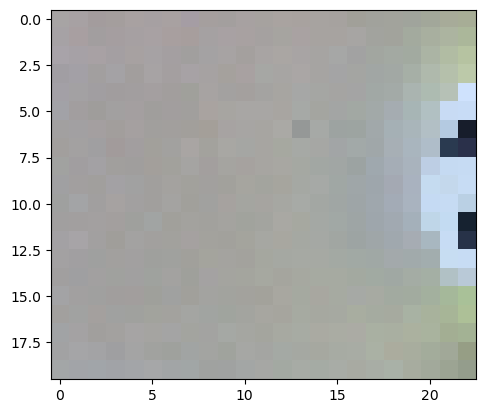

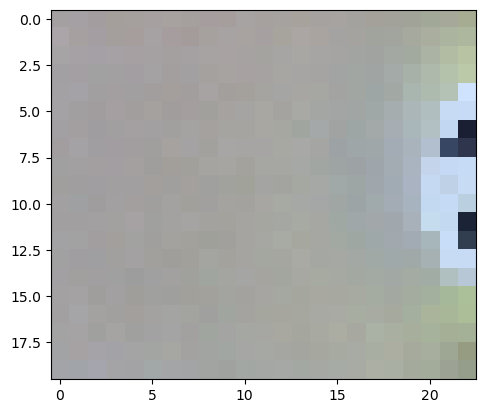

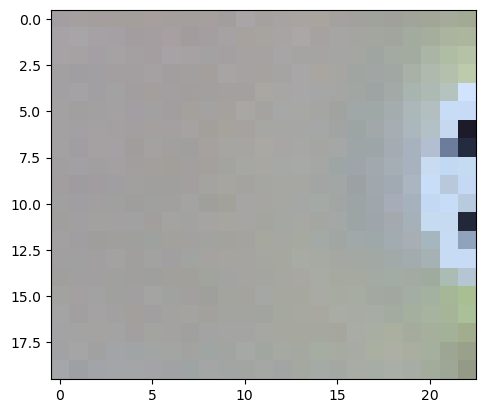

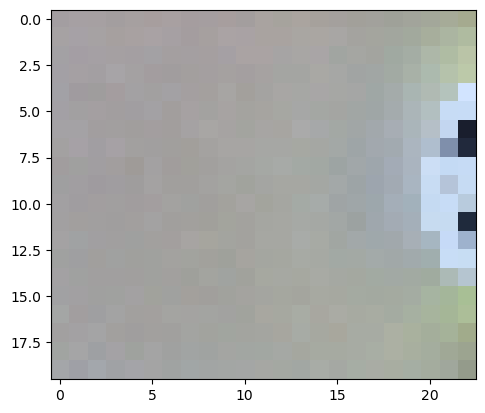

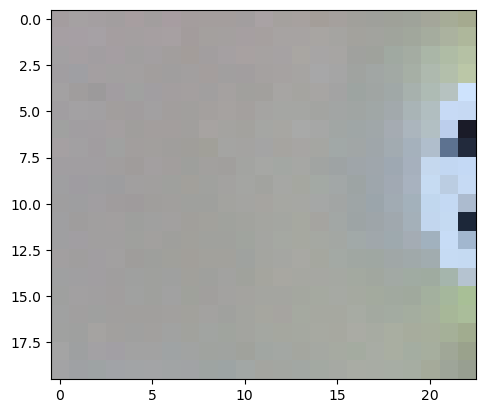

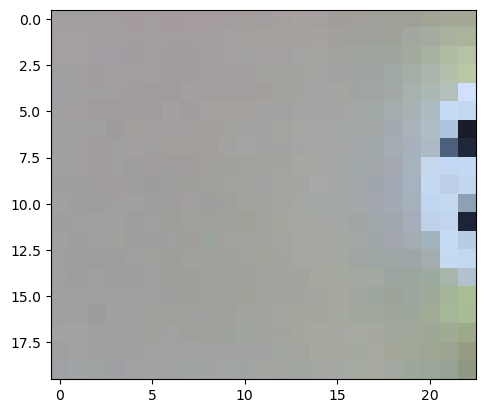

In [6]:
for image in df_tmp_image:
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

In [7]:
targets[0]

[-16.451969083548036,
 8.180300500834718,
 100.0,
 -49.72819052549832,
 -82.1451509312781]

In [8]:
target_tensors = list(
    map(
        lambda x: torch.tensor(x, dtype=torch.float32),
        targets,
    )
)
target_tensors[0].shape, len(target_tensors)

(torch.Size([5]), 810)

In [9]:
image_windows = list(map(lambda x: np.array(x), image_windows))
image_windows[0].shape

(30, 20, 23, 3)

Index(['shoulder_pan', 'shoulder_lift', 'wrist_flex', 'wrist_roll', 'gripper'], dtype='object')


<Axes: >

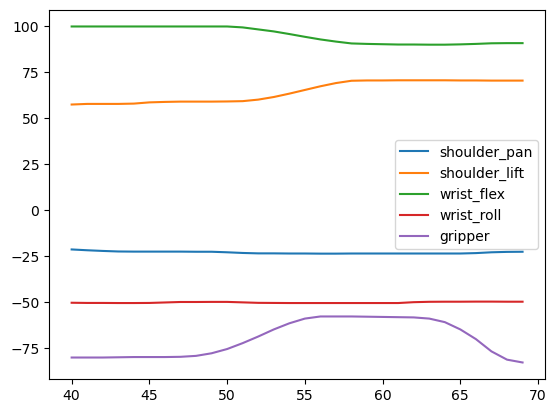

In [10]:
print(motor_windows[0].columns)
motor_windows[40].plot()

In [11]:
motor_windows[0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   shoulder_pan   30 non-null     float64
 1   shoulder_lift  30 non-null     float64
 2   wrist_flex     30 non-null     float64
 3   wrist_roll     30 non-null     float64
 4   gripper        30 non-null     float64
dtypes: float64(5)
memory usage: 1.4 KB


In [12]:
motor_windows = list(map(lambda x: x.to_numpy(), motor_windows))
motor_windows_original_shape = motor_windows[0].shape
print("shape", motor_windows_original_shape)

shape (30, 5)


In [13]:
motor_windows = list(map(lambda x: x.reshape(-1), motor_windows))
print("shape", motor_windows[0].shape)

shape (150,)


In [14]:
motor_window_tensors = list(
    map(lambda x: torch.tensor(x, dtype=torch.float32), motor_windows)
)
motor_window_tensors[0].shape, len(motor_window_tensors)

(torch.Size([150]), 810)

In [15]:
image_window_tensors = list(
    map(lambda x: torch.tensor(x, dtype=torch.float32), image_windows)
)
image_window_tensors[0].shape, len(image_window_tensors)

(torch.Size([30, 20, 23, 3]), 810)

In [16]:
class model(torch.nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.fc1 = torch.nn.Linear(150, 300)
        self.fc2 = torch.nn.Linear(300, 512)

        # Use smaller conv layers and more pooling to reduce parameters
        self.conv1 = torch.nn.Conv2d(
            in_channels=3, out_channels=8, kernel_size=3, padding=1
        )
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(8, 16, 3, padding=1)
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        self.conv3 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.pool3 = torch.nn.MaxPool2d(2, 2)
        self.flatten = torch.nn.Flatten(start_dim=0)
        self.fc_flat_image = torch.nn.Linear(12000, 512)

        self.fc3 = torch.nn.Linear(512 + 512, 512)
        self.fc4 = torch.nn.Linear(512, 5)

    def forward(self, x_motor, x_image):

        x_motor = torch.relu(self.fc1(x_motor))
        x_motor = torch.relu(self.fc2(x_motor))

        x_image = x_image.permute(0, 3, 1, 2)
        x_image = torch.relu(self.conv1(x_image))
        x_image = self.pool1(x_image)
        x_image = torch.relu(self.conv2(x_image))
        x_image = self.pool2(x_image)
        x_image = self.flatten(x_image)
        x_image = torch.relu(self.fc_flat_image(x_image))

        x = torch.cat((x_motor, x_image), dim=0)
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        return x


model_object = model()
model_object.eval()
out = model_object(motor_window_tensors[0], image_window_tensors[0])
out.shape, out, target_tensors[0].shape, target_tensors[0]

(torch.Size([5]),
 tensor([0.0000, 1.9298, 0.0000, 0.0000, 0.0000], grad_fn=<ReluBackward0>),
 torch.Size([5]),
 tensor([-16.4520,   8.1803, 100.0000, -49.7282, -82.1451]))

In [17]:
epochs = 10

optimizer = torch.optim.AdamW(model_object.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model_object.train()
    indices = np.arange(len(motor_window_tensors))
    np.random.shuffle(indices)
    for i in tqdm.tqdm(indices):
        optimizer.zero_grad()

        output = model_object(motor_window_tensors[i], image_window_tensors[i])
        loss = criterion(output, target_tensors[i])
        loss.backward()
        optimizer.step()

    print(f"{epoch:2d} Loss: {loss.item()}")

Epoch 1/10


100%|██████████| 810/810 [00:22<00:00, 36.23it/s]


 0 Loss: 1609.346923828125
Epoch 2/10


 10%|▉         | 77/810 [00:02<00:21, 33.46it/s]


KeyboardInterrupt: 

In [18]:
out = model_object(motor_window_tensors[0], image_window_tensors[0])
out.shape, out, target_tensors[0].shape, target_tensors[0]

(torch.Size([5]),
 tensor([ 0.0000, 31.0829, 99.1920,  0.0000,  0.0000], grad_fn=<ReluBackward0>),
 torch.Size([5]),
 tensor([-16.4520,   8.1803, 100.0000, -49.7282, -82.1451]))

In [19]:
out = model_object(motor_window_tensors[1], image_window_tensors[1])
out.shape, out, target_tensors[1].shape, target_tensors[1]

(torch.Size([5]),
 tensor([ 0.0000, 32.6805, 98.9946,  0.0000,  0.0000], grad_fn=<ReluBackward0>),
 torch.Size([5]),
 tensor([-17.5561,  13.4391, 100.0000, -49.7282, -82.1451]))

In [20]:
out = model_object(motor_window_tensors[10], image_window_tensors[10])
out.shape, out, target_tensors[10].shape, target_tensors[10]

(torch.Size([5]),
 tensor([ 0.0000, 51.6234, 99.0518,  0.0000,  0.0000], grad_fn=<ReluBackward0>),
 torch.Size([5]),
 tensor([-21.3839,  57.5125, 100.0000, -50.4012, -80.2184]))

In [21]:
# Save the model using TorchScript (JIT)
scripted_model = torch.jit.script(model_object)
scripted_model.save("model_jit_3.pt")

In [22]:
df = pd.DataFrame(
    columns=["shoulder_pan", "shoulder_lift", "wrist_flex", "wrist_roll", "gripper"]
)
df_pred = pd.DataFrame(
    columns=["shoulder_pan", "shoulder_lift", "wrist_flex", "wrist_roll", "gripper"]
)

for i in range(100):
    out = model_object(motor_window_tensors[i], image_window_tensors[i])
    df.loc[i] = target_tensors[i].numpy()
    df_pred.loc[i] = out.detach().numpy()

<Axes: >

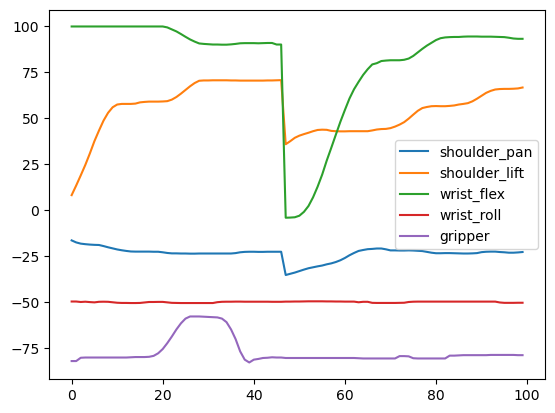

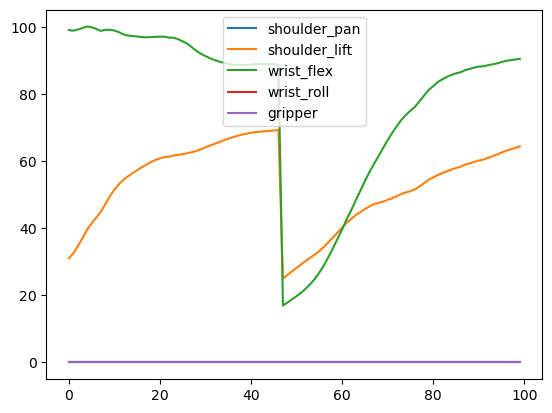

In [23]:
df.plot()
df_pred.plot()